### Loading Libraries and Dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
import random
import seaborn as sns

pd.set_option("display.max_column", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\hp\Downloads\WEEK 174 STATE LINELIST.csv")

#### Data Anonymization and Removing Irrelevant Columns

In [3]:
fake = Faker()

In [4]:
def anonymize_data(df):
    df['Patient_Name'] = df['Patient_Name'].apply(lambda x: fake.name())
    df['ART_ID'] = df['ART_ID'].apply(lambda x: fake.phone_number())
    df['Patient_Address'] = df['Patient_Address'].apply(lambda x: fake.address().replace('\n', ' '))
    df['Patient_LGA'] = df['Patient_LGA'].apply(lambda x: fake.address().replace('\n', ' '))
    return df

anonymized_df = anonymize_data(df)

In [5]:
anonymized_df = anonymized_df.drop(['Facility_Name', 'IP', 'Datim_Code', 'HospitalNo','Patient_LGA',
                                   'Patient_State', 'State', 'Phone_No'], axis = 1)

In [6]:
data = anonymized_df

### EDA and Data Cleaning

In [7]:
data.drop('Age_in_months', axis = 1, inplace = True)

In [8]:
data.drop('setting', axis = 1, inplace = True)

In [9]:
data['CurrentARTStatus'].unique()

array(['Active', 'LTFU', 'Death', 'Transferred out', 'Discontinued Care'],
      dtype=object)

In [10]:
conv_to_datetime = ['EnrollmentDate', 'ART_Start_Date', 'ViralLoadReportedDate', 'Clinic_Visit_Lastdate', 'Pharmacy_LastPickupdate',
                    'stamp_date', 'DateofCurrentViralLoad', 'ViralLoadReportedDate', 'LastDateOfSampleCollection', 'TBStatusDate',
                    'INHStartDate',	'INHStopDate',	'LastINHDispensedDate',	'TBTreatmentStartDate',	'TBTreatmentStopDate',	
                    'OTZStartDate',	'OTZStopDate', 'DateofFirstDTGPickup', 'Termination_Date', 'Next_Visit_Date',	
                    'Next_Ap_by_pharmPill',	'Next_Ap_by_careCard', 'Biometric_date', 'Date_Generated']

for col in conv_to_datetime:
    data[col] = pd.to_datetime(data[col], errors = 'coerce')                   

In [11]:
data.drop('DOB',axis = 1, inplace = True)

In [12]:
# Convert to integer
conv_to_int = ['current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'CurrentViralLoad', 'CurrentWeight_Kg', 'CurrentHeight_Kg', 'Days_To_Schedule']

for cols in conv_to_int:
    data[cols] = pd.to_numeric(data[cols], errors = 'coerce')

In [13]:
# performing a descriptive statistics
data.select_dtypes(['float', 'int']).describe()

,current_Age,Age_At_Start,DaysOfARVRefill,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_Kg,Days_To_Schedule
count,110483.000000,101373.000000,98620.000000,7.215100e+04,96096.000000,79141.000000,99003.000000
mean,37.398405,32.611070,138.558315,1.000956e+04,63.126291,163.274457,-363.611709
std,13.029286,12.066687,57.714790,4.011296e+05,15.769130,17.953361,1006.875580
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000,5.000000,-7301.000000
25%,28.000000,25.000000,90.000000,5.000000e+00,55.000000,158.000000,-37.000000
50%,36.000000,31.000000,180.000000,1.000000e+01,64.000000,165.000000,53.000000
75%,45.000000,40.000000,180.000000,1.900000e+01,72.000000,172.000000,100.000000
max,119.000000,113.000000,180.000000,1.000000e+08,250.000000,270.000000,180.000000


In [14]:
# calculate null percentage and drop columns above 50% null percentage
cols_above_50 = []
for cols in data.columns:
    null_percentage = data[cols].isnull().mean()*100
    if null_percentage > 50:
        cols_above_50.append(cols)

In [15]:
# drop these columns
data.drop(cols_above_50, axis = 1, inplace = True)

In [16]:
# categorical analysis
categorical_features = ['Sex', 'CurrentRegimenLine', 'TBStatus', 'Appointment_Status',
                       'RegimenLineAtARTStart',	'RegimenAtARTStart', 'CurrentARTRegimen', 'ViralLoadIndication', 'DTGFirstPickUp',	
                       'CurrentARTStatus',	'Biometric_Status']
for feature in categorical_features:
    print(f"{data[feature].value_counts()}\n")

Sex
F         63407
M         46355
Female      524
Male        197
Name: count, dtype: int64

CurrentRegimenLine
Adult 1st line ARV regimen     98205
Child 1st line ARV regimen      1933
Adult 2nd line ARV regimen      1208
Child 2nd line ARV regimen       100
Adult 3rd Line ARV Regimens       27
One                               24
Two                                1
Child 3rd Line ARV Regimens        1
AZT-3TC-DTG                        1
Name: count, dtype: int64

TBStatus
No signs or symptoms of disease    97519
Currently on INH prophylaxis        1460
Disease suspected                   1129
On treatment for disease             269
Completed treatment for disease      251
Disease diagnosed                    105
27-Jul-22                              1
Name: count, dtype: int64

Appointment_Status
Active With Drugs     71483
LTFU                  36481
Missed Appointment     2502
Today Visit              19
Name: count, dtype: int64

RegimenLineAtARTStart
Adult 1st line ARV regi

In [54]:
# convert categorical features to category
data[categorical_features] = data[categorical_features].astype('category')

In [17]:
# inconsistency in SEX, replace F with Female and M with Male
data['Sex'].replace({"F":'Female', 'M':'Male'}, inplace = True)

In [49]:
# rename height column
data.rename(columns={'CurrentHeight_Kg': 'CurrentHeight_cm'}, inplace=True)

In [18]:
# fill null values for numerical data.
average_female_age = data[data['Sex'] == 'Female']['Age_At_Start'].mean().round(0)
average_male_age = data[data['Sex'] == 'Male']['Age_At_Start'].mean().round(0)

In [19]:
data.loc[data['Sex'] == 'Female', 'Age_At_Start'] = data[data['Sex'] == 'Female']['Age_At_Start'].fillna(average_female_age)
data.loc[data['Sex'] == 'Male', 'Age_At_Start'] = data[data['Sex'] == 'Male']['Age_At_Start'].fillna(average_male_age)

In [51]:
data.isnull().sum()

ART_ID                            0
Sex                               2
current_Age                       0
Patient_Name                      0
Patient_Address                   0
Age_At_Start                      0
EnrollmentDate                    0
ART_Start_Date                    0
Clinic_Visit_Lastdate             0
Pharmacy_LastPickupdate           0
stamp_date                        0
DaysOfARVRefill                   0
RegimenLineAtARTStart          8985
RegimenAtARTStart              9537
CurrentRegimenLine             8985
CurrentARTRegimen             11910
CurrentViralLoad                  0
DateofCurrentViralLoad            0
LastDateOfSampleCollection        0
ViralLoadReportedDate             0
ViralLoadIndication           38225
CurrentWeight_Kg                  0
CurrentWeightDate             14388
CurrentHeight_cm                  0
CurrentHeightDate             31343
TBStatus                       9751
TBStatusDate                      0
INHStartDate                

In [26]:
# Using interpolate to fill null values
data = data.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None)

In [27]:
data.isnull().sum()

ART_ID                            0
Sex                               2
current_Age                       0
Patient_Name                      0
Patient_Address                   0
Age_At_Start                      0
EnrollmentDate                    0
ART_Start_Date                    0
Clinic_Visit_Lastdate             0
Pharmacy_LastPickupdate           0
stamp_date                        0
DaysOfARVRefill                   0
RegimenLineAtARTStart          8985
RegimenAtARTStart              9537
CurrentRegimenLine             8985
CurrentARTRegimen             11910
CurrentViralLoad                  0
DateofCurrentViralLoad            0
LastDateOfSampleCollection        0
ViralLoadReportedDate             0
ViralLoadIndication           38225
CurrentWeight_Kg                  0
CurrentWeightDate             14388
CurrentHeight_Kg                  0
CurrentHeightDate             31343
TBStatus                       9751
TBStatusDate                      0
INHStartDate                

<Axes: >

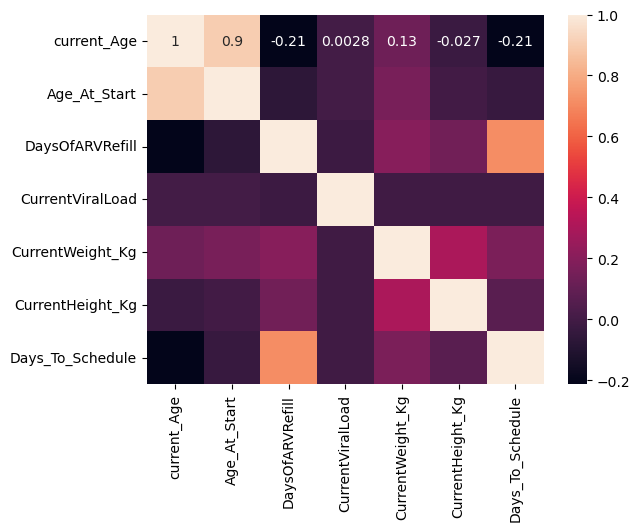

In [34]:
# Check correlation between variables
corr_matrix = data.select_dtypes(['int', 'float']).corr()
sns.heatmap(corr_matrix, annot = True)

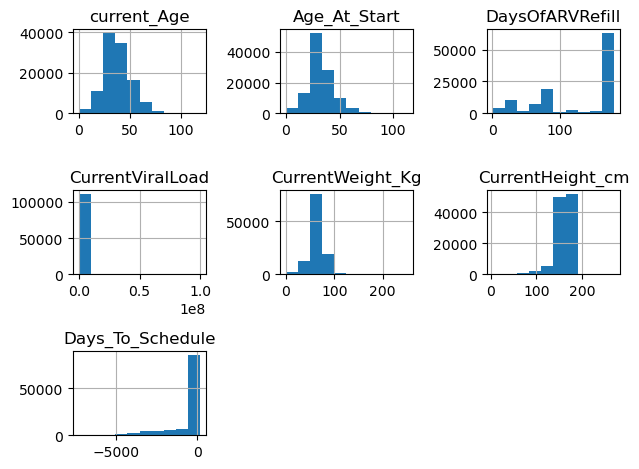

In [52]:
# check distribution for categorical variable
data.select_dtypes(['int', 'float']).hist()
plt.tight_layout()
plt.show()

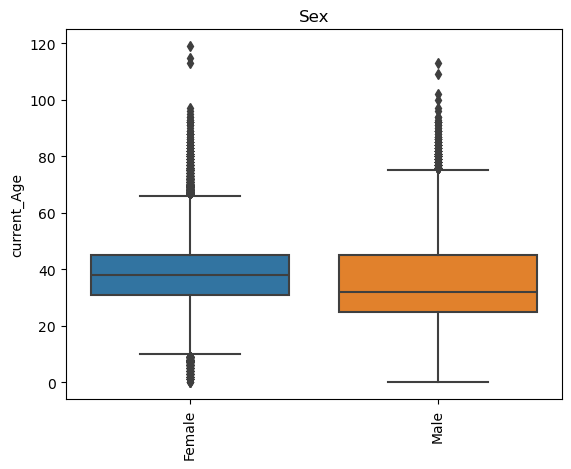

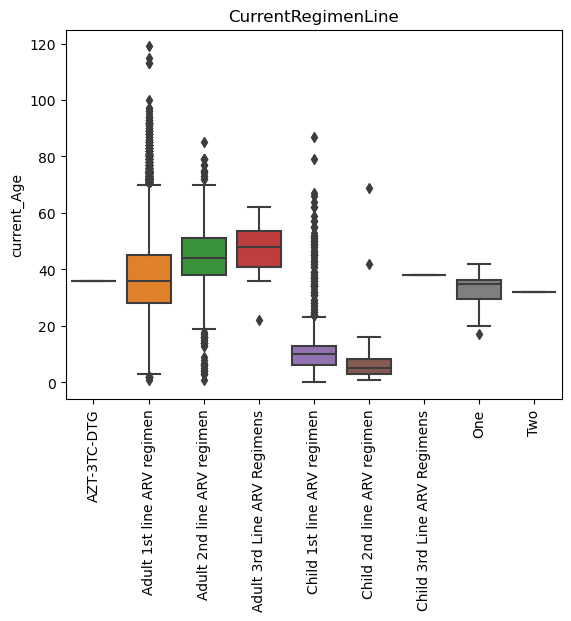

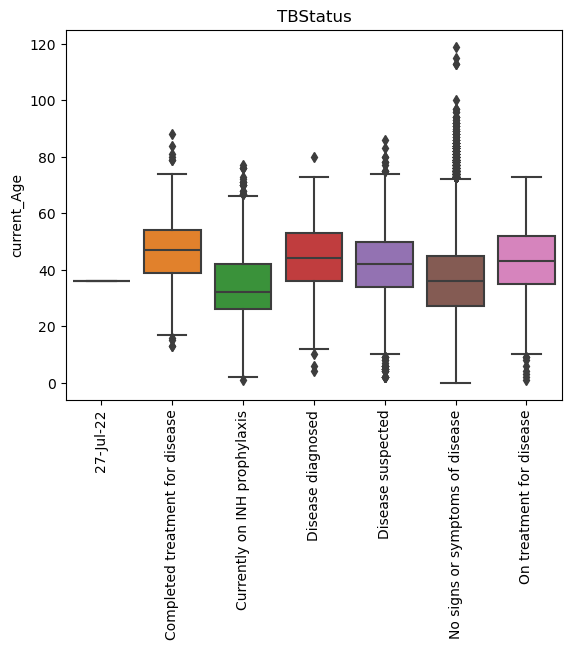

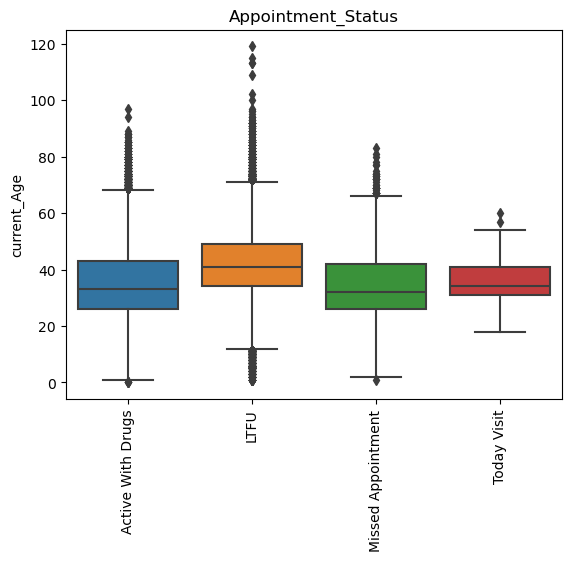

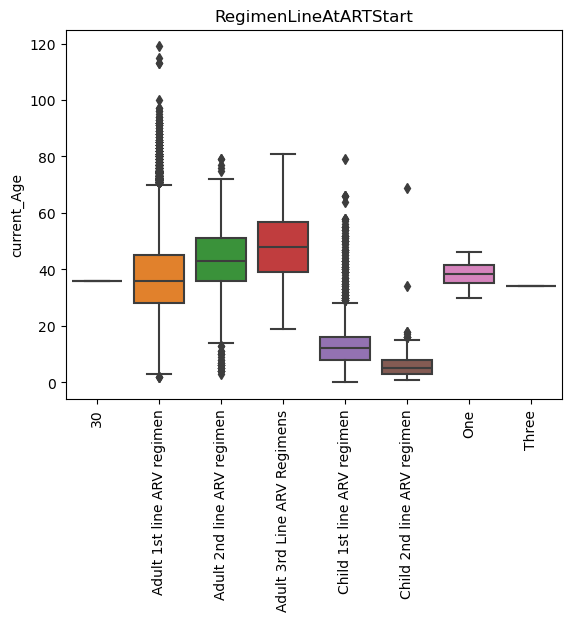

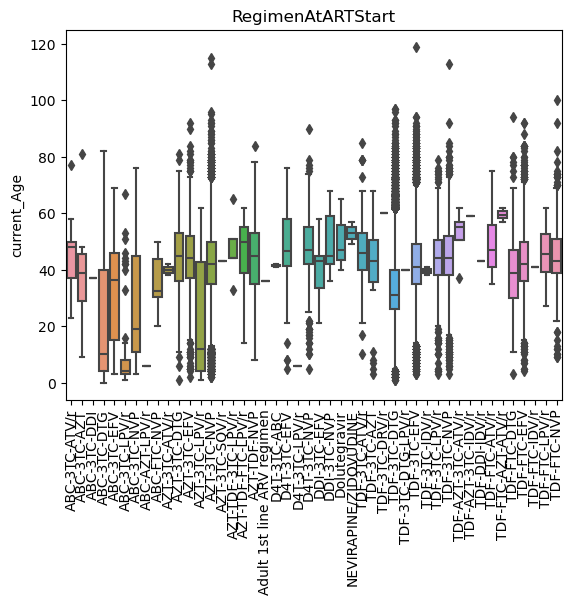

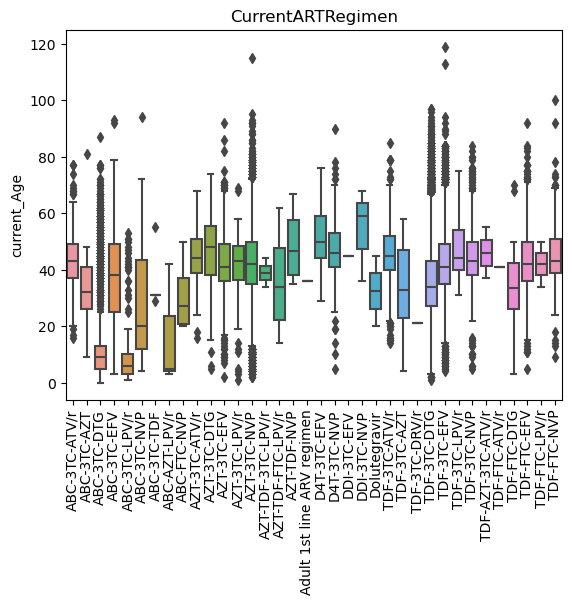

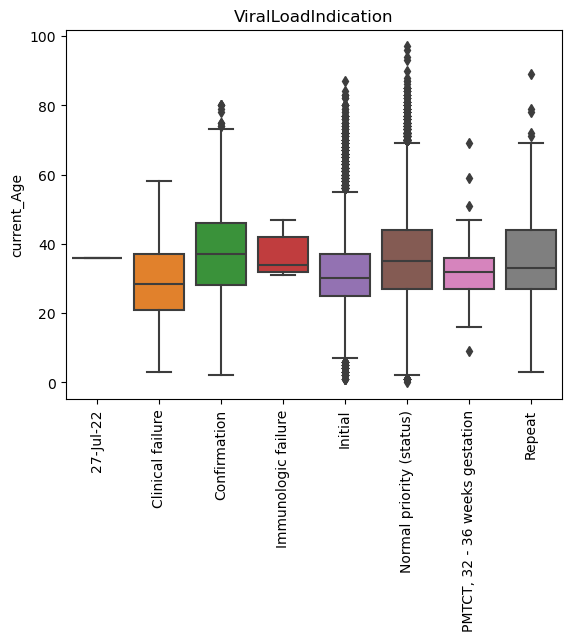

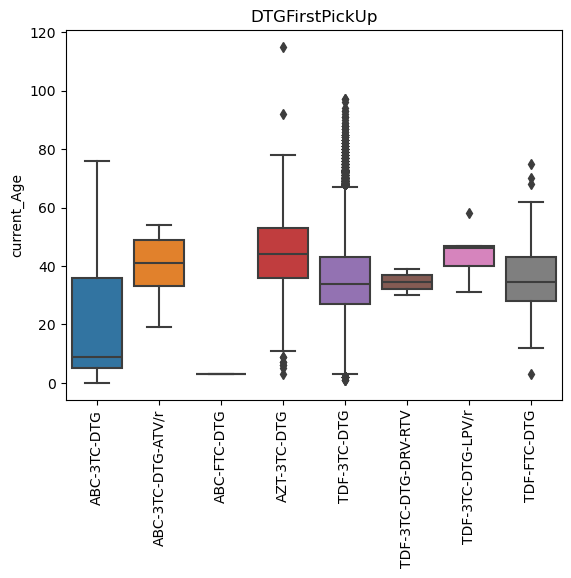

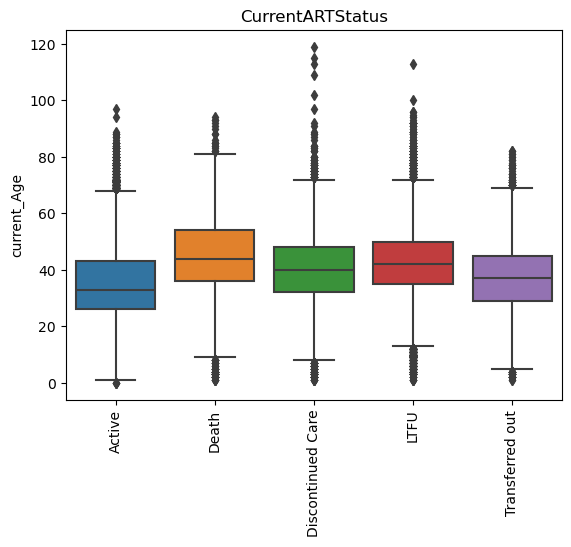

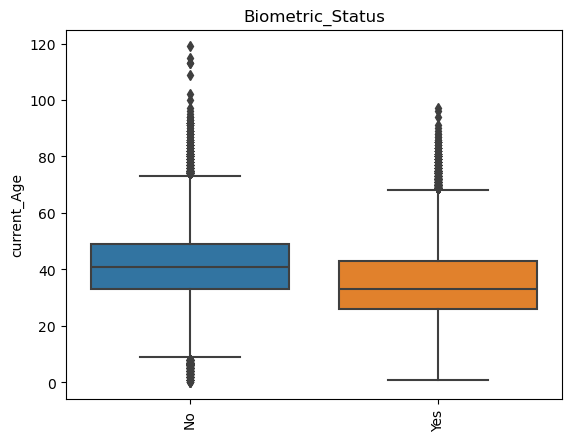

In [68]:
# plot distribution for categorical variable
for feature in categorical_features:
    sns.boxplot(x=feature, y='current_Age', data=data)
    plt.xticks(rotation = 90)
    plt.title(feature)
    plt.xlabel('')
    plt.show()

In [74]:
# discovered an inconsistency and clean "27-Jul-22"
data[data['TBStatus'] == '27-Jul-22']

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,stamp_date,DaysOfARVRefill,RegimenLineAtARTStart,RegimenAtARTStart,CurrentRegimenLine,CurrentARTRegimen,CurrentViralLoad,DateofCurrentViralLoad,LastDateOfSampleCollection,ViralLoadReportedDate,ViralLoadIndication,CurrentWeight_Kg,CurrentWeightDate,CurrentHeight_cm,CurrentHeightDate,TBStatus,TBStatusDate,INHStartDate,DTGFirstPickUp,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated
96353,3895736625,Male,36.0,Samantha Parker,"2851 James Manors North Thomasberg, MI 60373",32.0,2018-08-10 12:00:00,2018-11-12,2022-05-31 12:00:00,2022-07-27,2022-08-11 02:17:00,180.0,30,Adult 1st line ARV regimen,AZT-3TC-DTG,Adult 1st line ARV regimen,0.0,2022-03-03 12:00:00,2022-07-27,2022-07-27,27-Jul-22,67.75,59,165.0,165,27-Jul-22,2022-05-31 12:00:00,2022-07-27,TDF-3TC-DTG,2018-12-03,Active,Today Visit,2022-08-26,2022-08-26,2022-08-26,0.0,Yes,2021-01-20,2022-08-26 16:34:00


In [75]:
# drop the row
data = data[data['TBStatus'] != '27-Jul-22']

In [78]:
data[data['RegimenLineAtARTStart'] == '30'] # The above code has taken care of the 30 outlier in RegimenLineAtARTStart column

,ART_ID,Sex,current_Age,Patient_Name,Patient_Address,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,stamp_date,DaysOfARVRefill,RegimenLineAtARTStart,RegimenAtARTStart,CurrentRegimenLine,CurrentARTRegimen,CurrentViralLoad,DateofCurrentViralLoad,LastDateOfSampleCollection,ViralLoadReportedDate,ViralLoadIndication,CurrentWeight_Kg,CurrentWeightDate,CurrentHeight_cm,CurrentHeightDate,TBStatus,TBStatusDate,INHStartDate,DTGFirstPickUp,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated


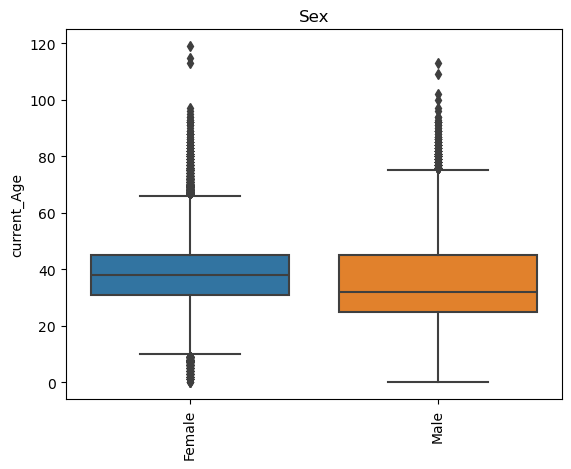

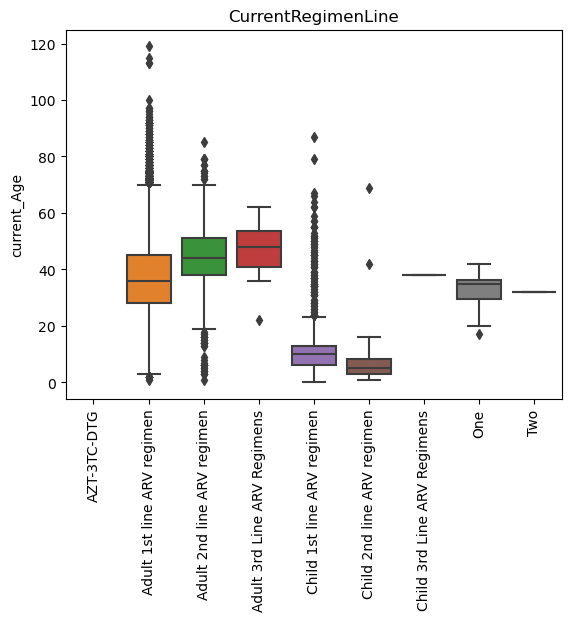

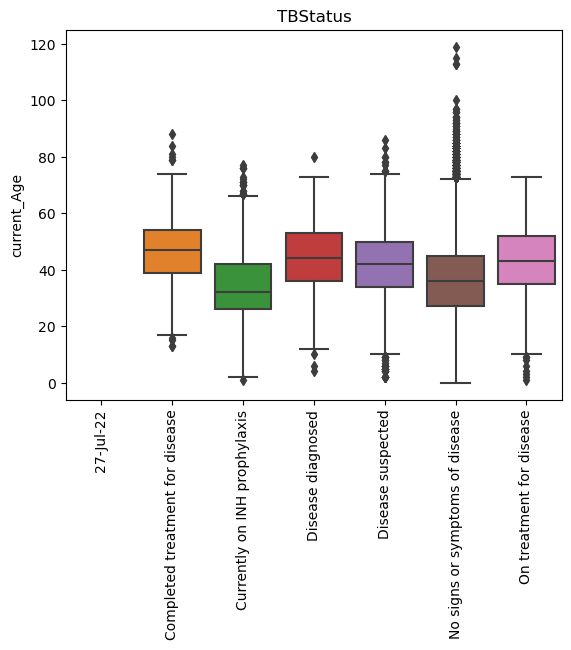

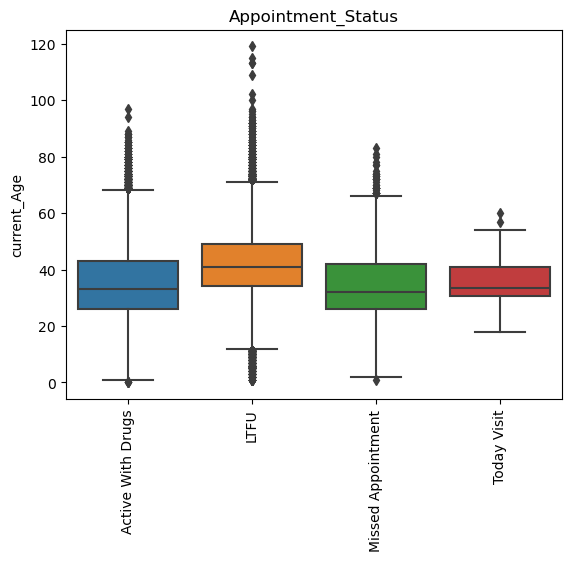

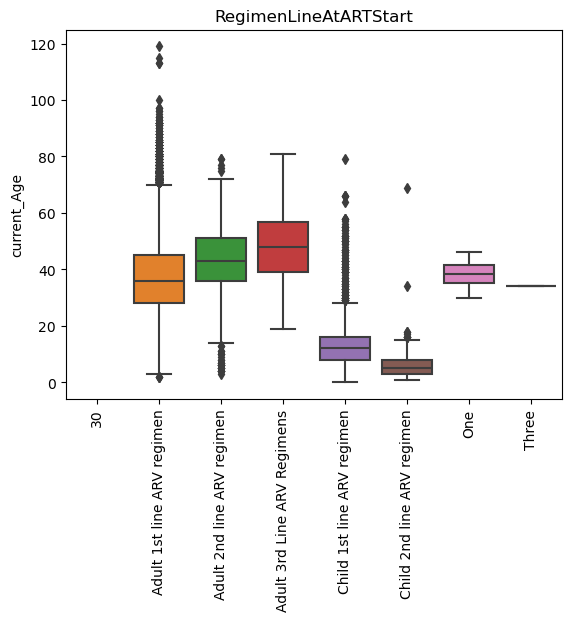

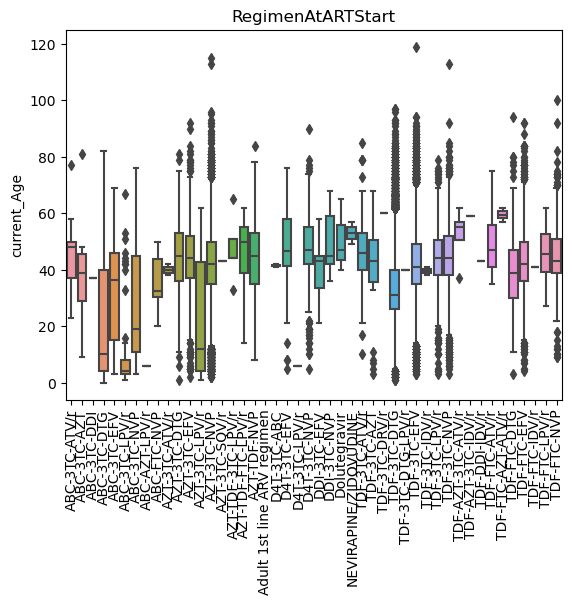

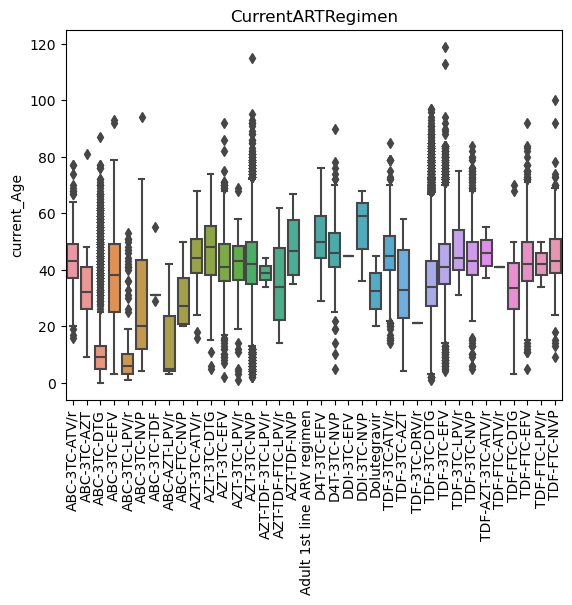

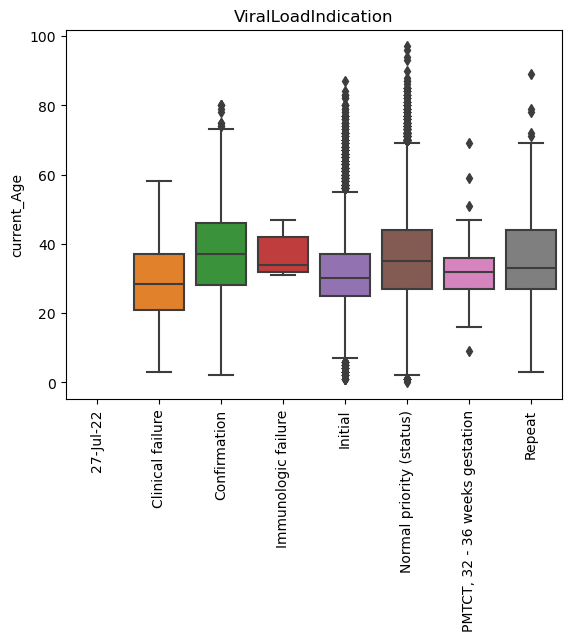

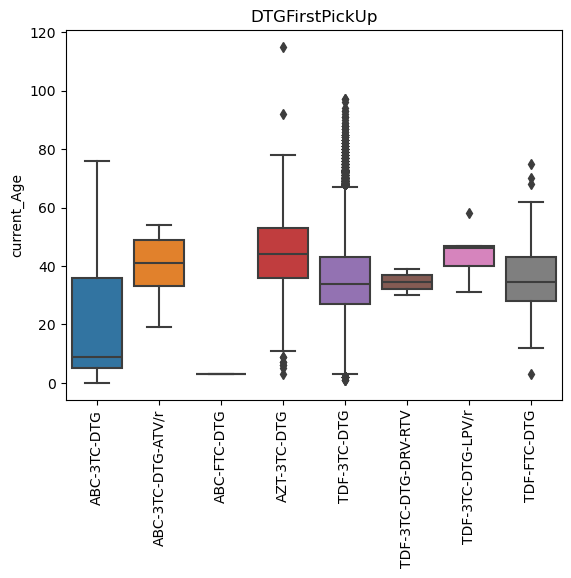

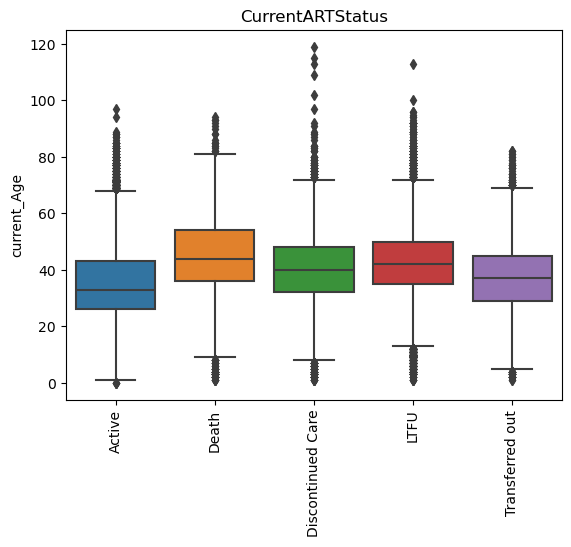

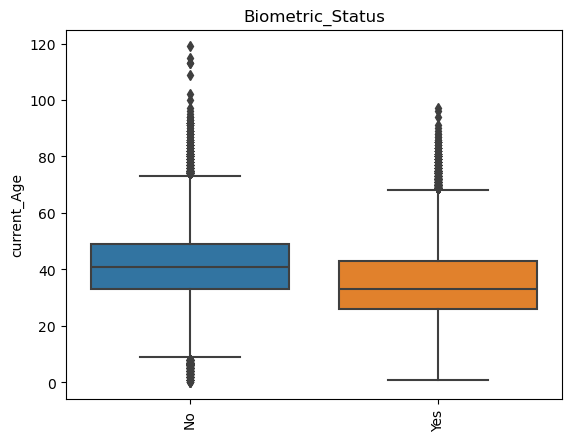

In [79]:
# plot distribution for categorical variable
for feature in categorical_features:
    sns.boxplot(x=feature, y='current_Age', data=data)
    plt.xticks(rotation = 90)
    plt.title(feature)
    plt.xlabel('')
    plt.show()